# **IMPORTADO DE MÓDULOS / DEFINICIÓN DE FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-04-25 23:12:45.004600: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 23:12:45.028828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 23:12:45.418649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from scipy.optimize import curve_fit
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [3]:
def momentos(vector):
  Nev,Nt,Nc = np.shape(vector)    #Nev: Núm eventos, Nt: Núm puntos temporales, Nc: Número canales
  t = np.reshape(np.linspace(0,Nt, Nt)/float(Nt),(1,-1,1))#Normalized array of time
  MOMENT = np.zeros((Nev,0,Nc))

  for i in range(4): #Number of moments used
    W = t**(i+1)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-(i)*t)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

    W = np.exp(-(t**i))
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)

  return MOMENT

In [4]:
#---------------------------------------------------- Normalization Function--------------------------------------------------------------
@njit
def normalize_by_max(array_pulsos):
  y = np.zeros_like(array_pulsos)
  for i in range(array_pulsos.shape[0]):
    y[i,:,0] =  array_pulsos[i,:,0] / np.max(array_pulsos[i,:,0])
    y[i,:,1] =  array_pulsos[i,:,1] / np.max(array_pulsos[i,:,1])
  return y

In [5]:
def simpsons_rule_array(y, h):
    array = np.zeros(y.shape[0])
    n = y.shape[1]

    for i in range(y.shape[0]):
      integral = y[i,0] + y[i,-1]

      for j in range(1, n, 2):
          integral += 4 * y[i,j]

      for j in range(2, n - 1, 2):
          integral += 2 * y[i,j]

      integral *= h / 3
      array[i] = integral

    return array

# **LOAD PULSES**

In [7]:
Nev_Co60 = 200000  #Nùmero de eventos en las prácticas del máster
Nev_Na22 = 150000
Nt = 600
Nc = 2

In [8]:
#pulsos_Co60 = np.zeros((Nev_Co60,Nt,Nc))
#
#with open('/home/josea/PracticaTimingDigital/pulsoCo60', 'rb') as file:
#  for i in range(Nev_Co60):
#    for j in range(Nt):
#      try:
#        pulsos_Co60[i,j, :] = np.fromfile(file, dtype=np.float32, count = 2)
#      except EOFError:
#        break
#
#    a1, a2 = np.fromfile(file, dtype=np.float32, count=2)

In [9]:
#np.savez_compressed('/home/josea/PracticaTimingDigital/pulsoCo60', data=pulsos_Co60)

In [10]:
data = np.load('/home/josea/PracticaTimingDigital/pulsoCo60.npz')
pulsos_Co60 = data['data']

# **ENERGY FILTERING**

## **DETECTOR 0: 1332 KeV - DETECTOR 1: 1173 KeV**

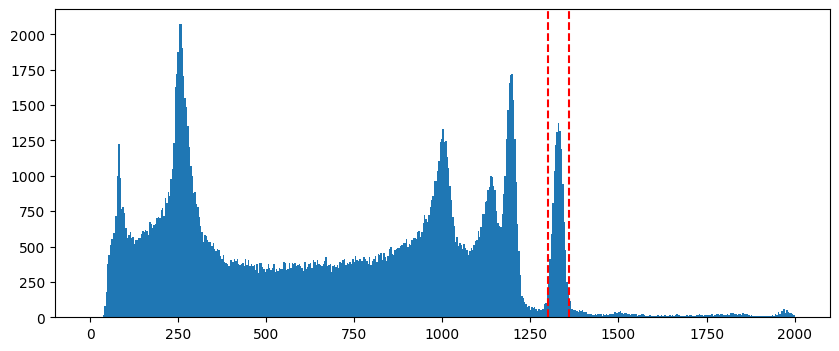

In [11]:
from scipy.signal import find_peaks
energy_dec0_comb1 = simpsons_rule_array(pulsos_Co60[:,50:550,0],1)


histogE, binsE = np.histogram(energy_dec0_comb1,bins=500,range=[0,200]);
index = find_peaks(histogE, height=1000)[0][-1]
m = 1332.5/((binsE[index+1]+binsE[index])/2)
calibrado_dec0_comb1 = m*energy_dec0_comb1


gate_min_dec0_comb1 = 1300
gate_max_dec0_comb1 = 1360
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec0_comb1,bins = 500, range = [0,2000]);
plt.axvline(x=gate_min_dec0_comb1, color='r', linestyle='--')
plt.axvline(x=gate_max_dec0_comb1, color='r', linestyle='--')

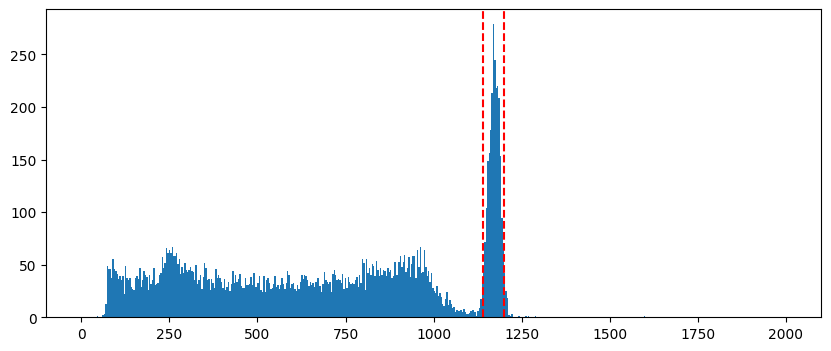

In [12]:
energy_dec1_comb1 = simpsons_rule_array(pulsos_Co60[(calibrado_dec0_comb1>gate_min_dec0_comb1)  & (calibrado_dec0_comb1<gate_max_dec0_comb1),50:550,1],1)

histogE, binsE = np.histogram(energy_dec1_comb1,bins=500,range=[0,200]);
index = find_peaks(histogE, height=200)[0][-1]
m = 1173.2/((binsE[index+1]+binsE[index])/2)
calibrado_dec1_comb1 = m*energy_dec1_comb1

gate_min_dec1_comb1 = 1140
gate_max_dec1_comb1 = 1200
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec1_comb1,bins=500, range = [0,2000])
plt.axvline(x=gate_min_dec1_comb1, color='r', linestyle='--')
plt.axvline(x=gate_max_dec1_comb1, color='r', linestyle='--')

## **DETECTOR 1: 1332 KeV - DETECTOR 0: 1173 Kev**

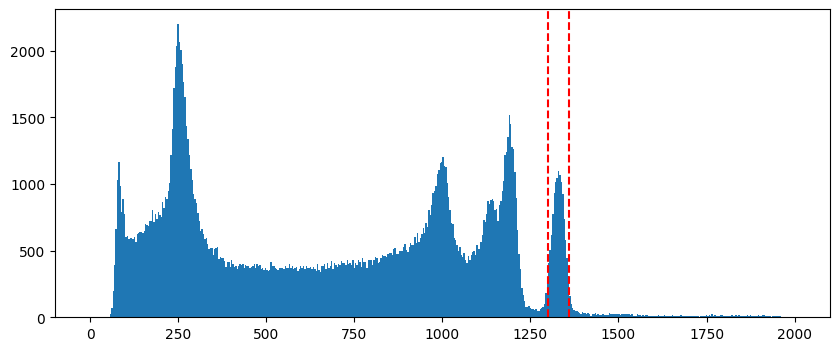

In [13]:
energy_dec1_comb2 = simpsons_rule_array(pulsos_Co60[:,50:550,1],1)

histogE, binsE = np.histogram(energy_dec1_comb2,bins=500,range=[0,200]);
index = find_peaks(histogE, height=1000)[0][-1]
m = 1332.5/((binsE[index+1]+binsE[index])/2)
calibrado_dec1_comb2 = m*energy_dec1_comb2

gate_min_dec1_comb2 = 1300
gate_max_dec1_comb2 = 1360
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec1_comb2,bins=500, range = [0,2000])
plt.axvline(x=gate_min_dec1_comb2, color='r', linestyle='--')
plt.axvline(x=gate_max_dec1_comb2, color='r', linestyle='--')

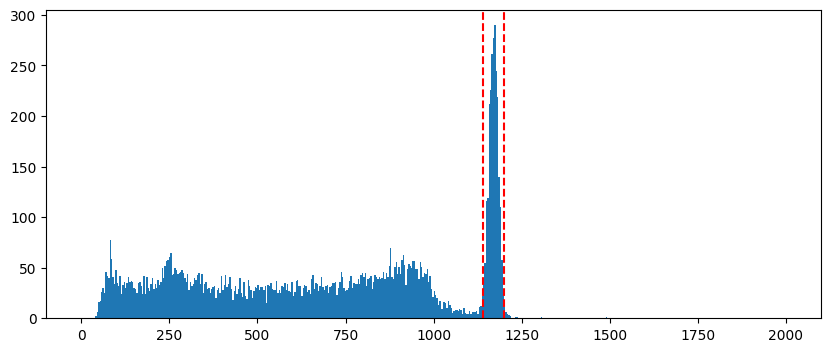

In [14]:
energy_dec0_comb2 = simpsons_rule_array(pulsos_Co60[(calibrado_dec1_comb2>gate_min_dec1_comb2)  & (calibrado_dec1_comb2<gate_max_dec1_comb2),50:550,0],1)


histogE, binsE = np.histogram(energy_dec0_comb2,bins=500,range=[0,200]);
index = find_peaks(histogE, height=200)[0][-1]
m = 1173.2/((binsE[index+1]+binsE[index])/2)
calibrado_dec0_comb2 = m*energy_dec0_comb2


gate_min_dec0_comb2 = 1140
gate_max_dec0_comb2 = 1200
plt.figure(figsize=(10,4))
plt.hist(calibrado_dec0_comb2,bins = 500, range = [0,2000]);
plt.axvline(x=gate_min_dec0_comb2, color='r', linestyle='--')
plt.axvline(x=gate_max_dec0_comb2, color='r', linestyle='--')

In [15]:
pulsos_Co60_filt_comb1 = pulsos_Co60[(calibrado_dec0_comb1>gate_min_dec0_comb1)  & (calibrado_dec0_comb1<gate_max_dec0_comb1),:,:]
pulsos_Co60_filt_comb1 = pulsos_Co60_filt_comb1[(calibrado_dec1_comb1>gate_min_dec1_comb1)  & (calibrado_dec1_comb1<gate_max_dec1_comb1),:,:]
pulsos_Co60_filt_comb2 = pulsos_Co60[(calibrado_dec1_comb2>gate_min_dec1_comb2)  & (calibrado_dec1_comb2<gate_max_dec1_comb2),:,:]
pulsos_Co60_filt_comb2 = pulsos_Co60_filt_comb2[(calibrado_dec0_comb2>gate_min_dec0_comb2)  & (calibrado_dec0_comb2<gate_max_dec0_comb2),:,:]


pulsos_Co60_filt = np.concatenate((pulsos_Co60_filt_comb1, pulsos_Co60_filt_comb2), axis = 0)
print(pulsos_Co60_filt.shape)

#------------------------------------------------------- Normalizar Pulsos ------------------------------------------------------------------------------------
pulsos_Co60_filt_norm = normalize_by_max(pulsos_Co60_filt)

(4798, 600, 2)


# **CHECK FOR OUTLIERS**

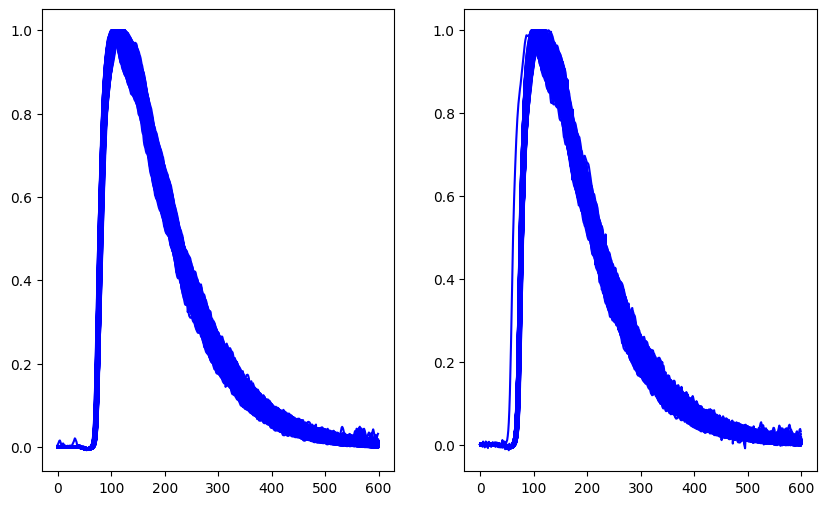

In [16]:
pulsos_Co60_filt_norm = np.delete(pulsos_Co60_filt_norm, 1383, axis=0)

#------------------------------------ Con el plot se ve si hay algún pulso que empiece mal/que no cuadre con el otro detector
a = []
plt.figure(figsize=(10,6))
for i in range(pulsos_Co60_filt_norm.shape[0]):
  plt.subplot(121)
  plt.plot(pulsos_Co60_filt_norm[i,:,0], 'b-')
  plt.subplot(122)
  plt.plot(pulsos_Co60_filt_norm[i,:,1], 'b-')
  a.append(np.where(pulsos_Co60_filt_norm[i,:,0] == np.max(pulsos_Co60_filt_norm[i,:,0]))[0][0])
a = np.array(a)

#print(np.where(a == np.min(a)))

# **INTERPOLATE**

In [19]:
#--------------------------------Interpolar pulsos reales---------------------------------
start = 50
stop = 80
input = pulsos_Co60_filt_norm[:,start:stop,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func = interp1d(tiempo,pulsos_Co60_filt_norm[:,start:stop,:],  kind='cubic', axis=1)
new_pulses = interp_func(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

#---------------------------------------------------------------- Align the pulses -----------------------------------
new_pulses[:,:,1] = np.roll(new_pulses[:,:,1],20)
new_pulses[:,0:20,1] = np.random.normal(scale=1e-3, size=20)


Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


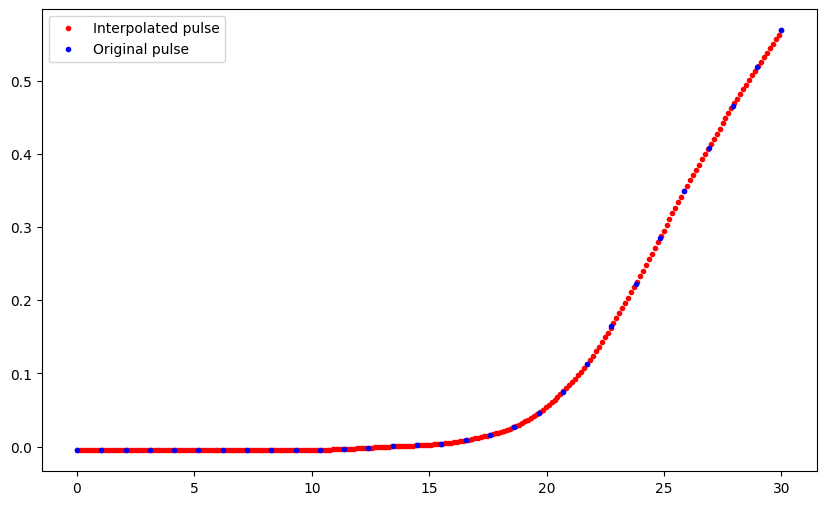

In [20]:
plt.figure(figsize=(10,6))

t_new = np.linspace(0,Nt,Nt_new)
t = np.linspace(0,Nt,Nt)
plt.plot(t_new,new_pulses[0,:,0],'r.')
plt.plot(t,pulsos_Co60_filt_norm[0,start:stop,0],'b.')
plt.legend(('Interpolated pulse','Original pulse'))

# **CREATE TEST SET**

In [21]:
#----------------------------------------------------- Create test set ---------------------------
Ntest = int(0.2*new_pulses.shape[0])
TEST = new_pulses[0:Ntest,:,:]
new_pulses = new_pulses[Ntest:,:,:]
print(TEST.shape)

(959, 240, 2)


In [22]:
t_shift = 8

TEST_02 = np.zeros_like(TEST)
TEST_20 = np.zeros_like(TEST)

for i in range(TEST.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size=TEST.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  TEST_02[i,:,0] = TEST[i,:,0]
  TEST_02[i,:,1] = np.roll(TEST[i,:,1], t_shift)
  TEST_02[i,:,1] = TEST_02[i,:,1] + smoothed_noise
  TEST_02[i,:t_shift,1] = noise00


for i in range(TEST.shape[0]):
  noise00 = np.random.normal(scale=1e-3, size=t_shift)
  noise0 = np.random.normal(scale=0.01, size=TEST.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  TEST_20[i,:,1] = TEST[i,:,1]
  TEST_20[i,:,0] = np.roll(TEST[i,:,0], t_shift)
  TEST_20[i,:,0] = TEST_20[i,:,0] + smoothed_noise
  TEST_20[i,:t_shift,0] = noise00


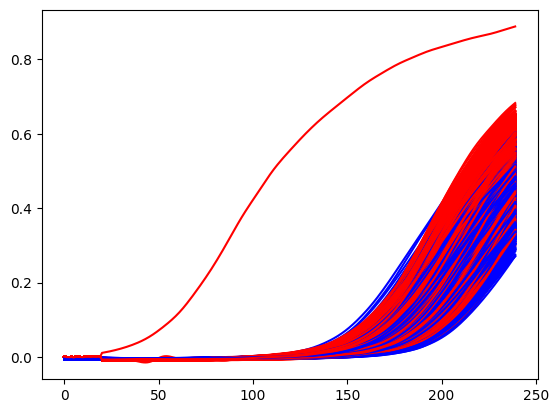

In [23]:
for i in range(new_pulses.shape[0]):
  plt.plot(new_pulses[i,:,0],'b-')
  plt.plot(new_pulses[i,:,1],'r-')

# **DETECTOR 0**

In [30]:
Ncasos = new_pulses.shape[0]
INPUT0_dec0 = np.zeros_like(new_pulses)
REF_dec0 = np.zeros((Ncasos,))


NRD0 = np.random.randint(20,size = Ncasos)
NRD1 = np.random.randint(20,size = Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=1e-3, size=N0)
  noise0 = np.random.normal(scale=0.01, size=new_pulses.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  INPUT0_dec0[i,:,0] = np.roll(new_pulses[i,:,0], N0)
  INPUT0_dec0[i,:,0] = INPUT0_dec0[i,:,0] + smoothed_noise
  INPUT0_dec0[i,:N0,0] = noise00

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=1e-3, size=N1)
  noise1 = np.random.normal(scale=0.01, size=new_pulses.shape[1])
  smoothed_noise = gaussian_filter1d(noise1, sigma=10)
  INPUT0_dec0[i,:,1] = np.roll(new_pulses[i,:,0], N1)
  INPUT0_dec0[i,:,1] = INPUT0_dec0[i,:,1]  + smoothed_noise
  INPUT0_dec0[i,:N1,1] = noise11
  REF_dec0[i] = new_time_step*(N0-N1)


trainX_dec0 = INPUT0_dec0[:,:,:]
REF_train_dec0 = REF_dec0[:]

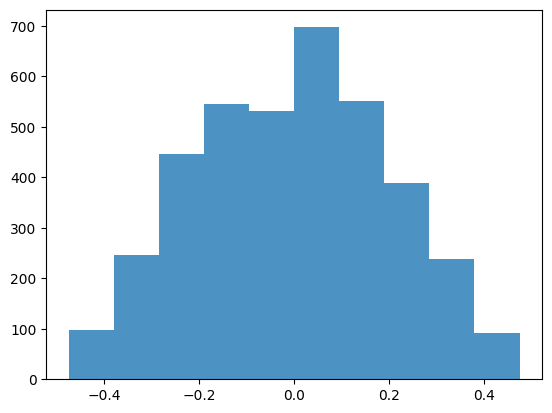

In [31]:
plt.hist(REF_train_dec0, alpha=0.8, histtype='bar');

In [32]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(3838, 12, 2) NM = 12


# **DETECTOR 1**

In [33]:
Ncasos = new_pulses.shape[0]
INPUT0_dec1 = np.zeros_like(new_pulses)
REF_dec1 = np.zeros((Ncasos,))


NRD0 = np.random.randint(20,size = Ncasos)
NRD1 = np.random.randint(20,size = Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=1e-3, size=N0)
  noise0 = np.random.normal(scale=0.01, size=new_pulses.shape[1])
  smoothed_noise = gaussian_filter1d(noise0, sigma=10)
  INPUT0_dec1[i,:,0] = np.roll(new_pulses[i,:,1], N0)
  INPUT0_dec1[i,:,0] = INPUT0_dec1[i,:,0] + smoothed_noise
  INPUT0_dec1[i,0:N0,0] = noise00

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=1e-3, size=N1)
  noise1 = np.random.normal(scale=0.01, size=new_pulses.shape[1])
  smoothed_noise = gaussian_filter1d(noise1, sigma=10)
  INPUT0_dec1[i,:,1] = np.roll(new_pulses[i,:,1], N1)
  INPUT0_dec1[i,:,1] = INPUT0_dec1[i,:,1] + smoothed_noise
  INPUT0_dec1[i,0:N1,1] = noise11
  REF_dec1[i] = new_time_step*(N0-N1)


trainX_dec1 = INPUT0_dec1[:,:,:]
REF_train_dec1 = REF_dec1[:]

In [36]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)

(3838, 12, 2) NM = 12


# **NEURAL NETWORK**

In [37]:
def weights_definition(NM, Npoints):
  t = np.linspace(0,Npoints, Npoints)/float(Npoints) #Normalized array of time
  Weights = np.zeros((Npoints,NM))
  NMW = int(NM/3) #Number of Moments per weight

  for i in range(NMW):
    Weights[:,i] = t**(i+1)

  for i in range(NMW):
    Weights[:,i + NMW] = np.exp(-t**(i))

  for i in range(NMW):
    Weights[:,i + 2*(NMW)] = np.exp(-(i)*t)

  return Weights

#----------------------------------------------------------------------------------------
NM = 12
weights = weights_definition(NM,Nt_new)

In [43]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))


  x1 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x2 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x3 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1), kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")
  #16 o 32 neuronas parecen ser las mas estables/robustas en cuanto a cambio de semilla.

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model



#------------------------------------------------------------------------------------------------------

def model_definition_manual_weight_initialization(N_time_points):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  x1 = Dense(NM, activation="relu", weights=[weights, np.zeros(NM)])
  #x1 = Dense(NM, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x4 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5), kernel_regularizer=l2(0.01))
  x5 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

# **FULL TOF**

In [44]:
REFERENCE_PULSE_dec0 = np.tile(new_pulses[0,:,0], (new_pulses.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_pulses[0,:,1], (new_pulses.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

In [45]:
M_Test_00 = momentos(TEST)
M_Test_00_norm = np.zeros_like(M_Test_00)
M_Test_00_norm[:,:,0] = (M_Test_00[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_00_norm[:,:,1] = (M_Test_00[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_Test_02 = momentos(TEST_02)
M_Test_02_norm = np.zeros_like(M_Test_02)
M_Test_02_norm[:,:,0] = (M_Test_02[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_02_norm[:,:,1] = (M_Test_02[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_Test_20 = momentos(TEST_20)
M_Test_20_norm = np.zeros_like(M_Test_20)
M_Test_20_norm[:,:,0] = (M_Test_20[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Test_20_norm[:,:,1] = (M_Test_20[:,:,1] - min_dec1)/(max_dec1-min_dec1)

M_Train =  momentos(new_pulses)
M_Train_norm= np.zeros_like(M_Train)
M_Train_norm[:,:,0] = (M_Train[:,:,0] - min_dec0)/(max_dec0-min_dec0)
M_Train_norm[:,:,1] = (M_Train[:,:,1] - min_dec1)/(max_dec1-min_dec1)

In [46]:
epochs = 200
num_semillas = 10

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_02_list = []
TOFN_00_list = []
TOFN_20_list = []

for i in range(num_semillas):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=5e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=5e-3)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_02_epoch = []
  TOFN_00_epoch = []
  TOFN_20_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs=1, batch_size = 512, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs=1, batch_size = 512, verbose=1)

     loss_dec0.append(history_dec0.history['loss'])
     loss_dec1.append(history_dec1.history['loss'])

     TOFN_dec0_REF_02 = np.squeeze(model_dec0.predict([M_REF_dec0[:M_Test_02_norm.shape[0],:,0],M_Test_02_norm[:,:,0]]))
     TOFN_dec1_REF_02 = np.squeeze(model_dec1.predict([M_REF_dec1[:M_Test_02_norm.shape[0],:,0],M_Test_02_norm[:,:,1]]))

     TOFN_dec0_REF_00 = np.squeeze(model_dec0.predict([M_REF_dec0[:M_Test_00_norm.shape[0],:,0],M_Test_00_norm[:,:,0]]))
     TOFN_dec1_REF_00 = np.squeeze(model_dec1.predict([M_REF_dec1[:M_Test_00_norm.shape[0],:,0],M_Test_00_norm[:,:,1]]))

     TOFN_dec0_REF_20 = np.squeeze(model_dec0.predict([M_REF_dec0[:M_Test_20_norm.shape[0],:,0],M_Test_20_norm[:,:,0]]))
     TOFN_dec1_REF_20 = np.squeeze(model_dec1.predict([M_REF_dec1[:M_Test_20_norm.shape[0],:,0],M_Test_20_norm[:,:,1]]))
    
    
     TOFN_02 = TOFN_dec0_REF_02 - TOFN_dec1_REF_02
     TOFN_00 = TOFN_dec0_REF_00 - TOFN_dec1_REF_00
     TOFN_20 = TOFN_dec0_REF_20 - TOFN_dec1_REF_20
    
     TOFN_02_epoch.append(TOFN_02)
     TOFN_00_epoch.append(TOFN_00)
     TOFN_20_epoch.append(TOFN_20)


     centroid_02 = -1*np.mean(TOFN_02) + np.mean(TOFN_00)
     centroid_20 = -1*np.mean(TOFN_20) + np.mean(TOFN_00)
     mean_error_centroid = (abs(centroid_02 + 0.2) + abs(centroid_20 - 0.2)) / 2
     mean_std = (np.std(TOFN_02) + np.std(TOFN_00) + np.std(TOFN_20)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_02_list.append(TOFN_02_epoch)
  TOFN_00_list.append(TOFN_00_epoch)
  TOFN_20_list.append(TOFN_20_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_02_array = np.array(TOFN_02_list, dtype = 'object')
TOFN_00_array = np.array(TOFN_00_list, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_list, dtype = 'object')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 365.1391
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 340.7704
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 332.8954
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 321.6154
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 311.3906
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 303.9340
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
30/30 ━━━━━━━━━━━

(array([0]), array([16])) 0.07598996178918452


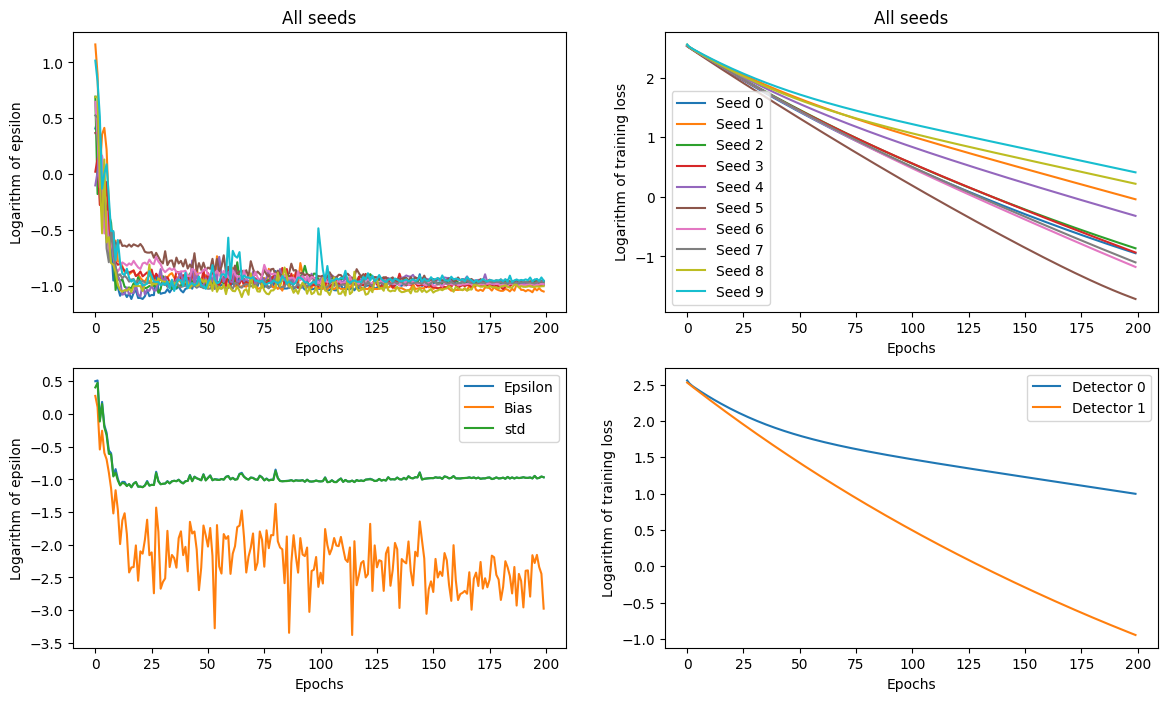

In [48]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  #plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


02: CENTROID(ns) = -0.191  FWHM(ns) = 0.168  std(ns) = 0.071
00: CENTROID(ns) = 0.004  FWHM(ns) = 0.174  std(ns) = 0.074
20: CENTROID(ns) = 0.207  FWHM(ns) = 0.184  std(ns) = 0.078


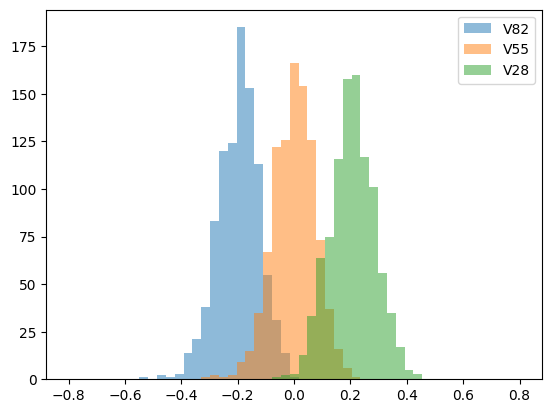

In [49]:
epoch = 16
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_02, binsN, patchesN  = plt.hist(-1*TOFN_02_array[index,epoch,:] + np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_02)

histogN, binsN, patchesN  = plt.hist(-1*TOFN_00_array[index,epoch,:] + np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)

histogN_20, binsN, patchesN  = plt.hist(-1*TOFN_20_array[index,epoch,:] + np.mean(TOFN_00_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_20)
plt.legend()


FWHMN_02 = 2.35482 * sigmaN_02
FWHMN = 2.35482 * sigmaN
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **ENSEMBLE MODEL**

In [50]:
#--------------------------- Get the mean results from all tries/seeds --------------------------
mean_02 = np.squeeze(np.mean(TOFN_02_array, axis=0))[epoch,:]
mean_00 = np.squeeze(np.mean(TOFN_00_array, axis=0))[epoch,:]
mean_20 = np.squeeze(np.mean(TOFN_20_array, axis=0))[epoch,:]


02: CENTROID(ns) = -0.193  FWHM(ns) = 0.224  std(ns) = 0.095
00: CENTROID(ns) = 0.004  FWHM(ns) = 0.241  std(ns) = 0.102
20: CENTROID(ns) = 0.206  FWHM(ns) = 0.237  std(ns) = 0.100


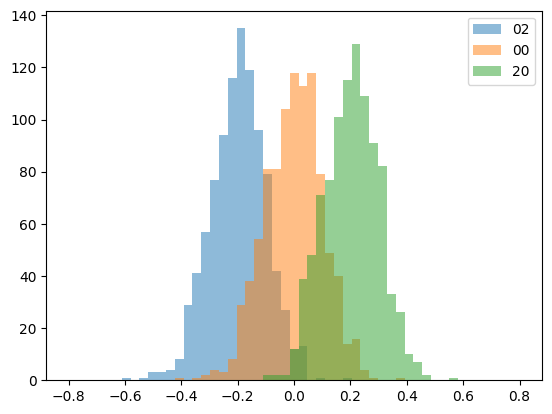

In [51]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_02, binsN, patchesN  = plt.hist(-1*mean_02 + np.mean(mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='02');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_02)

histogN, binsN, patchesN  = plt.hist(-1*mean_00 + np.mean(mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='00');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)

histogN_20, binsN, patchesN  = plt.hist(-1*mean_20 + np.mean(mean_00),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='20');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_20)
plt.legend()


FWHMN_02 = 2.35482 * sigmaN_02
FWHMN = 2.35482 * sigmaN
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))